# Evaluating cellpose hyperparameters

NOTE : use provided env for this notebook.

Evaluates performance on the images generated by `generate_cellpose_hyperparameters.ipynb`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys
sys.path.append("../")
from stardist.matching import matching_dataset
from tifffile import imread
from pathlib import Path
import matplotlib.pyplot as plt

from plots import *
from utils import *

SAVE_AS_SVG = True
SAVE_AS_PNG = False

In [3]:
image_path = Path("./cellpose_hyperparams_test")
images_path = list(image_path.glob("*.tif"))
images = [imread(str(img)) for img in images_path]
names = []
cellpose_count = 0

for img in images_path:
    if "cellpose" in img.stem:
        # threshold is after _t_ and before _r, can be negative !
        cellpose_count += 1
        thresh = img.stem.split("_t_")[1].split("_r")[0]
        if thresh == "0":
            thresh = "0 (Default)"
        # resample = img.stem.split("_r_")[1]
        name = f"Cellpose - Threshold {thresh}" # - Resample {resample}"
        names.append(name)
    else:
        names.append(img.stem)

GT_labels = imread(str(image_path / "gt/visual_labels.tif"))

In [4]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


model_stats = []
names_stats = []

for i, p in enumerate(images):
    print(f"Validating on {names[i]}")
    if len(p.shape) > 3:
        p = p[0].astype(np.uint64)
    stats = [matching_dataset(
        GT_labels, 
        p,
        thresh=t, 
        show_progress=False
        ) for t in taus]
    model_stats.append(stats)
    for t in taus:
        names_stats.append(names[i])
    # uncomment for ALL plots : 
    # plot_performance(taus, stats, name=names[i])
    print("*"*20)

Validating on Cellpose - Threshold -10
********************
Validating on Cellpose - Threshold -11
********************
Validating on Cellpose - Threshold -7
********************
Validating on Cellpose - Threshold -8
********************
Validating on Cellpose - Threshold -9
********************
Validating on Cellpose - Threshold 0 (Default)
********************
Validating on SegResNet
********************
Validating on SwinUnetR
********************


In [5]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Params"] = names_stats
df

,criterion,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality,by_image,Params
thresh,,,,,,,,,,,,,,,
0.1,iou,332,2690,695,0.890139,0.794682,0.723702,0.839707,3385,3022,0.541791,0.681770,0.572487,False,Cellpose - Threshold -10
0.2,iou,351,2671,714,0.883852,0.789069,0.714936,0.833776,3385,3022,0.540930,0.685528,0.571577,False,Cellpose - Threshold -10
0.3,iou,408,2614,771,0.864990,0.772230,0.689164,0.815983,3385,3022,0.536755,0.695071,0.567166,False,Cellpose - Threshold -10
0.4,iou,490,2532,853,0.837856,0.748006,0.653419,0.790386,3385,3022,0.528316,0.706299,0.558249,False,Cellpose - Threshold -10
0.5,iou,675,2347,1038,0.776638,0.693353,0.578079,0.732636,3385,3022,0.504622,0.727800,0.533212,False,Cellpose - Threshold -10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.5,iou,892,2849,536,0.761561,0.841654,0.666121,0.799607,3385,3741,0.688671,0.818235,0.654266,False,SwinUnetR
0.6,iou,1151,2590,795,0.692328,0.765140,0.570988,0.726916,3385,3741,0.647943,0.846829,0.615573,False,SwinUnetR
0.7,iou,1540,2201,1184,0.588345,0.650222,0.446904,0.617738,3385,3741,0.573097,0.881388,0.544467,False,SwinUnetR


In [6]:
# get cellpose_count first color of tab20 as rgb hex
cellpose_color = get_n_shades(COLORMAP[1], n_shades=cellpose_count)
colormap = cellpose_color + [COLORMAP[2], COLORMAP[3]]
colormap

['#000000',
 '#0E1433',
 '#1C2966',
 '#2B3E99',
 '#3953CC',
 '#4767FF',
 '#7209B7',
 '#F72585']

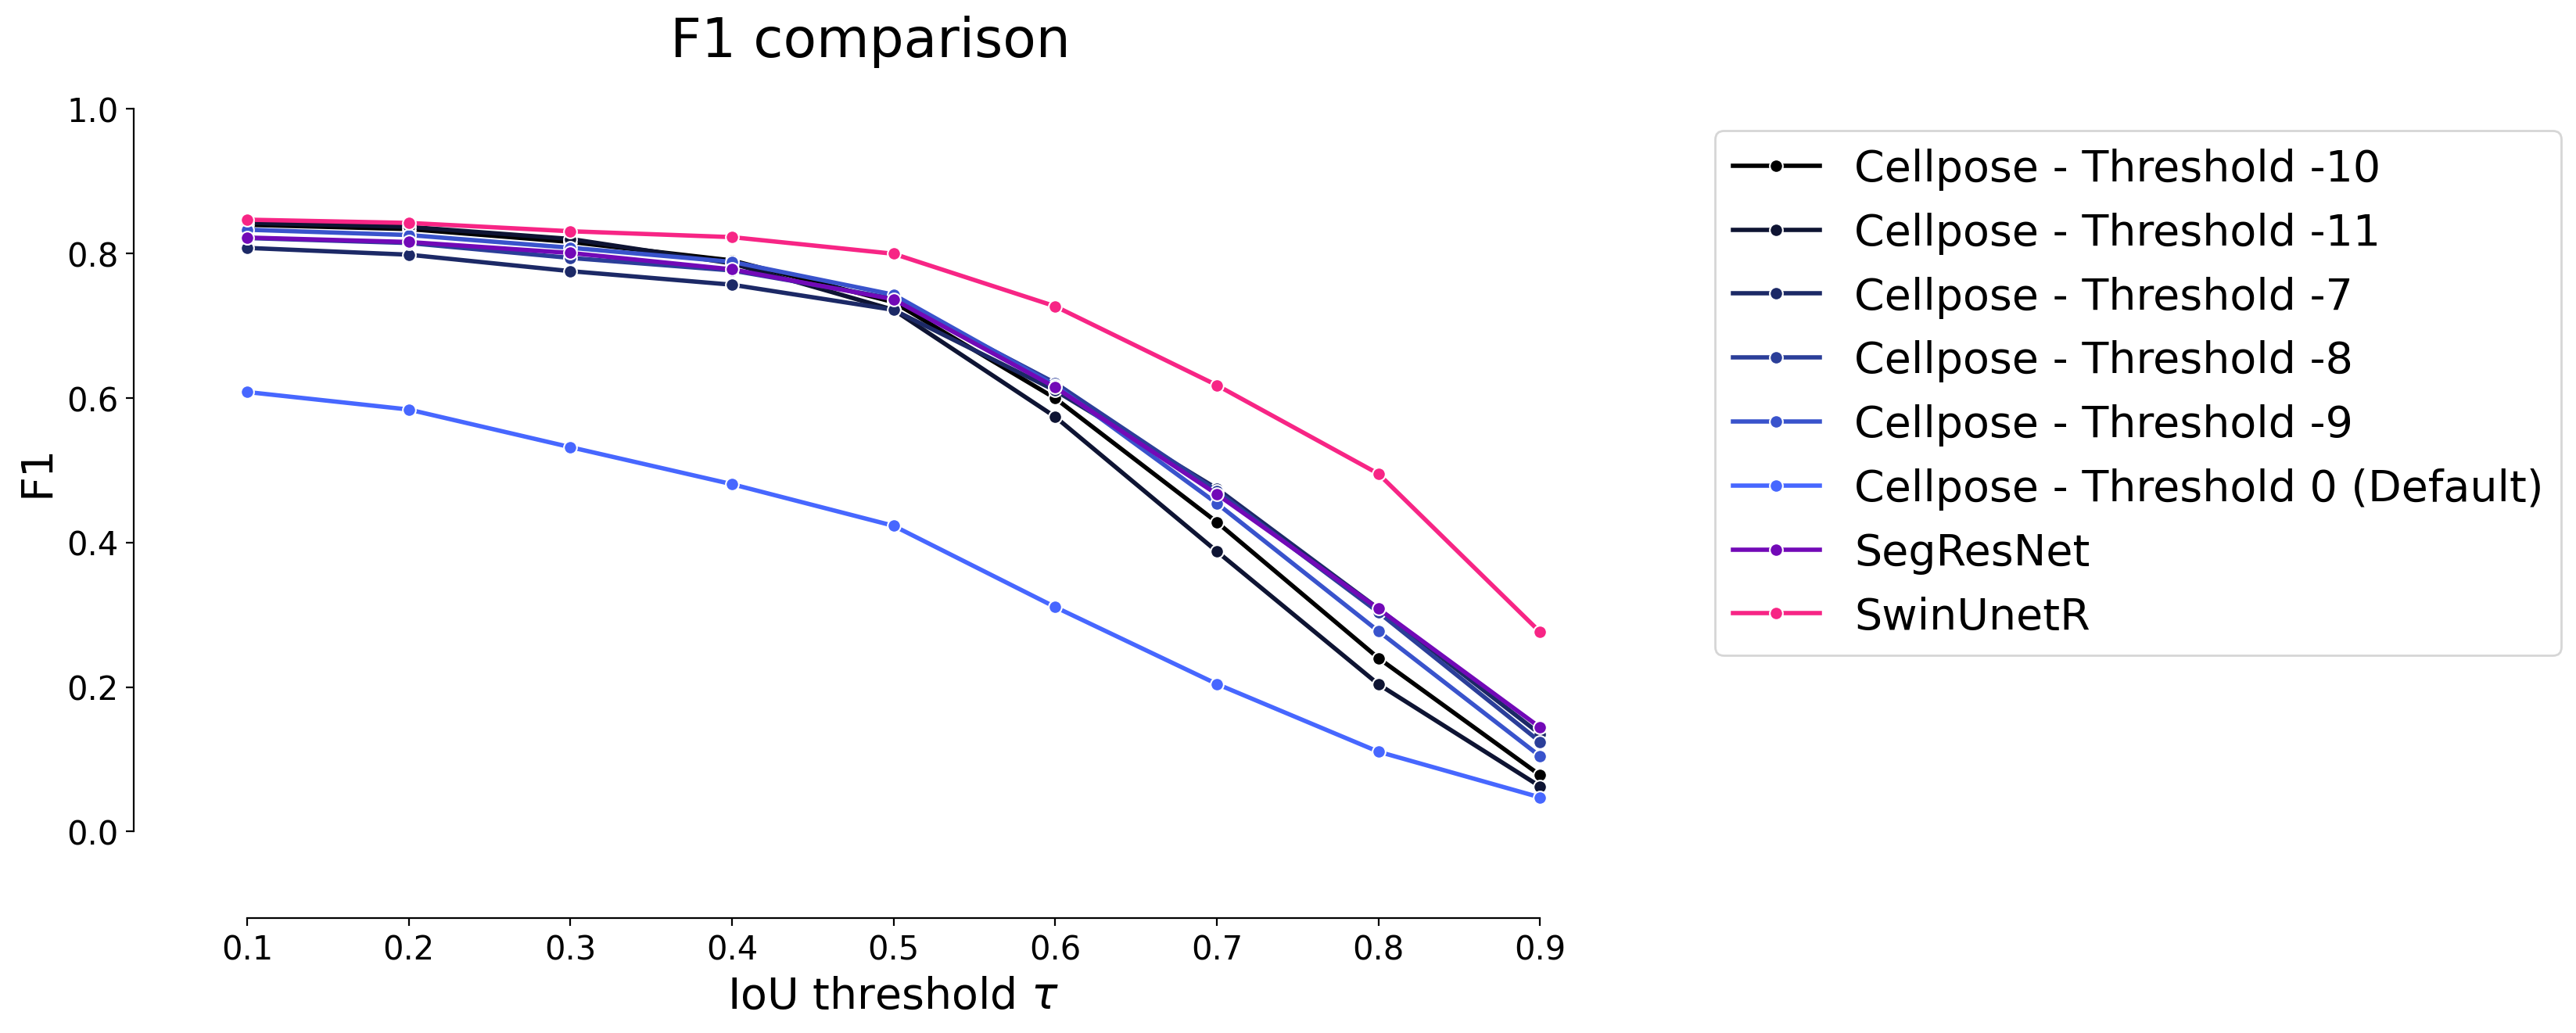

In [7]:
plot_stat_comparison(taus=taus, stats_list=model_stats, model_names=names, metric="IoU", colormap=colormap)
if SAVE_AS_PNG:
    plt.savefig(f"cellpose_hyperparams_test_iou.png", format="png")
if SAVE_AS_SVG:
    plt.savefig(f"cellpose_hyperparams_test_iou.svg", format="svg", bbox_inches='tight')